In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Path to dataset files: /kaggle/input/brats-2021-task1


In [ ]:
!pip install nibabel tensorflow matplotlib scikit-learn

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

DATA PREPROCESSING

In [ ]:
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

In [ ]:
def normalize_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    if img_max - img_min == 0:
        return image
    return (image - img_min) / (img_max - img_min)

In [ ]:
def preprocess_brats_data(image_path, mask_path, slice_index=75, target_size=(128, 128)):
    # Load 3D volumes
    image_3d = load_nifti_file(image_path)
    mask_3d = load_nifti_file(mask_path)

    # Extract 2D slice
    image_2d = image_3d[:, :, slice_index]
    mask_2d = mask_3d[:, :, slice_index]

    # Simple binary mask (combining all tumor classes: 1, 2, 4 in BraTS)
    mask_2d = (mask_2d > 0).astype(np.float32)

    # Resize and Normalize
    image_2d = tf.image.resize(image_2d[..., np.newaxis], target_size).numpy()
    mask_2d = tf.image.resize(mask_2d[..., np.newaxis], target_size, method='nearest').numpy()

    image_2d = normalize_image(image_2d)

    return image_2d, mask_2d

U-NET MODEL ARCHITECTURE

In [ ]:
def build_unet(input_shape=(128, 128, 4)):
    inputs = Input(shape=input_shape)
    def conv_block(x, filters, dropout_rate=0):
      x = layers.Conv2D(filters, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)

      x = layers.Conv2D(filters, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)

      if dropout_rate > 0:
          x = layers.Dropout(dropout_rate)(x)
      return x

    # Encoder (Contracting Path)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn)

    # Decoder (Expanding Path)
    u1 = layers.UpSampling2D((2, 2))(bn)
    u1 = layers.concatenate([u1, c3])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.concatenate([u3, c1])
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

METRICS & TRAINING

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def total_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

In [ ]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

VISUALIZATION

In [ ]:
def plot_results(image, ground_truth, prediction):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input MRI (FLAIR)")
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth[:, :, 0], cmap='Reds', alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction[:, :, 0] > 0.5, cmap='Blues', alpha=0.5)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

EXECUTION BLOCK

In [ ]:
data_path = '/kaggle/input/brats-2021-task1'

In [ ]:
import tarfile
import os
file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')

/tmp/ipython-input-2449183184.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall('./BraTS2021_Training_Data')


In [ ]:
file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_00621.tar')
file.extractall('./sample_img')
nSample = os.listdir('./sample_img')
nSample

/tmp/ipython-input-3755261487.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall('./sample_img')


['BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz']

In [ ]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_t2.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz']

In [ ]:
image_paths = []
mask_paths = []

for patient_dir in os.listdir(TRAIN_DATASET_PATH):
    patient_path = os.path.join(TRAIN_DATASET_PATH, patient_dir)
    if os.path.isdir(patient_path):
        flair_image_path = os.path.join(patient_path, f"{patient_dir}_flair.nii.gz")
        seg_mask_path = os.path.join(patient_path, f"{patient_dir}_seg.nii.gz")

        if os.path.exists(flair_image_path) and os.path.exists(seg_mask_path):
            image_paths.append(flair_image_path)
            mask_paths.append(seg_mask_path)

print(f"Found {len(image_paths)} FLAIR images and {len(mask_paths)} segmentation masks.")

Found 1251 FLAIR images and 1251 segmentation masks.


In [ ]:
preprocessed_images = []
preprocessed_masks = []

# Loop through image and mask paths and preprocess the data
for img_path, msk_path in zip(image_paths, mask_paths):
    image, mask = preprocess_brats_data(img_path, msk_path, slice_index=75, target_size=(128, 128))
    preprocessed_images.append(image)
    preprocessed_masks.append(mask)

# Convert lists to NumPy arrays
X = np.array(preprocessed_images)
y = np.array(preprocessed_masks)

print(f"Shape of preprocessed images (X): {X.shape}")
print(f"Shape of preprocessed masks (y): {y.shape}")

Shape of preprocessed images (X): (1251, 128, 128, 1)
Shape of preprocessed masks (y): (1251, 128, 128, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1000, 128, 128, 1)
Shape of X_test: (251, 128, 128, 1)
Shape of y_train: (1000, 128, 128, 1)
Shape of y_test: (251, 128, 128, 1)


In [ ]:
model = build_unet(input_shape=(128, 128, 4))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=total_loss, metrics=[dice_coef, iou_coef, 'accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_90[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ conv2d_91[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_18… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_92[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ conv2d_93[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_94[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 16, 16,    │          0 │ conv2d_95[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_96[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_18    │ (None, 32, 32,    │          0 │ conv2d_97[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 32, 32,    │          0 │ up_sampling2d_18… │
│ (Concatenate)       │ 192)              │            │ conv2d_95[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_98[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_19    │ (None, 64, 64,    │          0 │ conv2d_99[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
print("Model training complete.")

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9716 - dice_coef: 0.1391 - iou_coef: 0.0752 - loss: 0.9708 - val_accuracy: 0.9723 - val_dice_coef: 0.2188 - val_iou_coef: 0.1231 - val_loss: 0.8695
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9708 - dice_coef: 0.2831 - iou_coef: 0.1662 - loss: 0.7952 - val_accuracy: 0.9795 - val_dice_coef: 0.3779 - val_iou_coef: 0.2344 - val_loss: 0.6894
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9769 - dice_coef: 0.3593 - iou_coef: 0.2211 - loss: 0.7114 - val_accuracy: 0.9858 - val_dice_coef: 0.4905 - val_iou_coef: 0.3264 - val_loss: 0.5612
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9855 - dice_coef: 0.5098 - iou_coef: 0.3440 - loss: 0.5429 - val_accuracy: 0.9877 - val_dice_coef: 0.6439 - val_iou_coef: 0.4771 - val_loss: 0.4035
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9848 - dice_coef: 0.6606 - iou_coef: 0.4967 - loss: 0.3928 - val_accuracy: 0


Evaluating model on test set...
Test Loss: 0.1514
Test Dice Coefficient: 0.8793
Test IoU Coefficient: 0.7849
Test Accuracy: 0.9938

Visualizing sample predictions...

Sample 1:


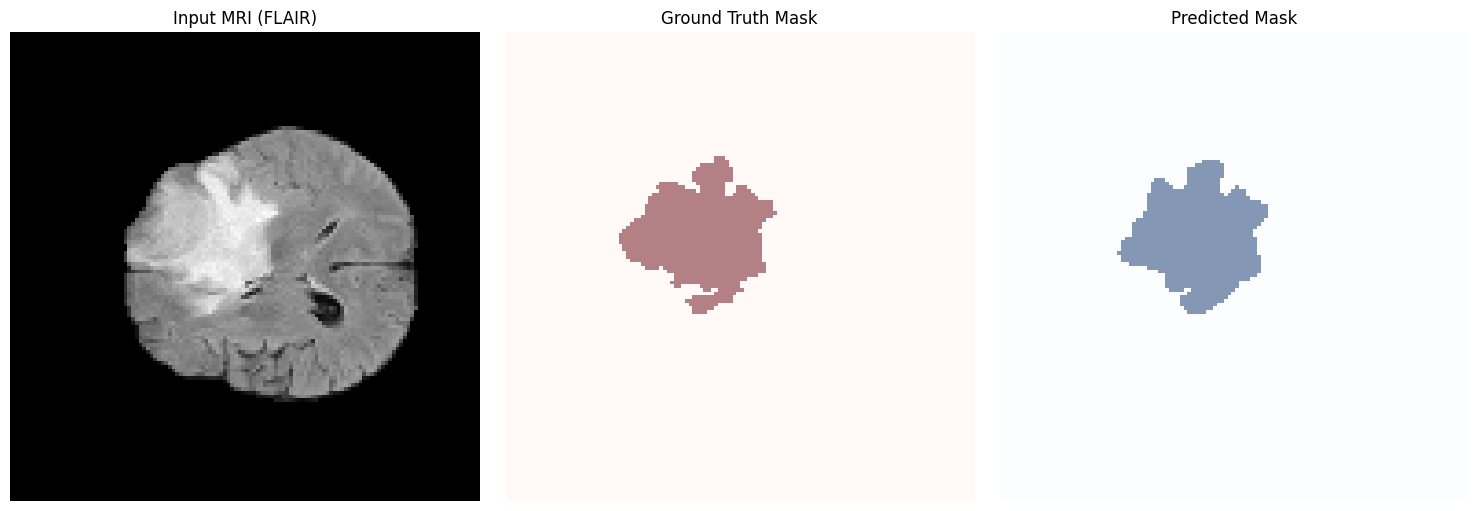


Sample 2:


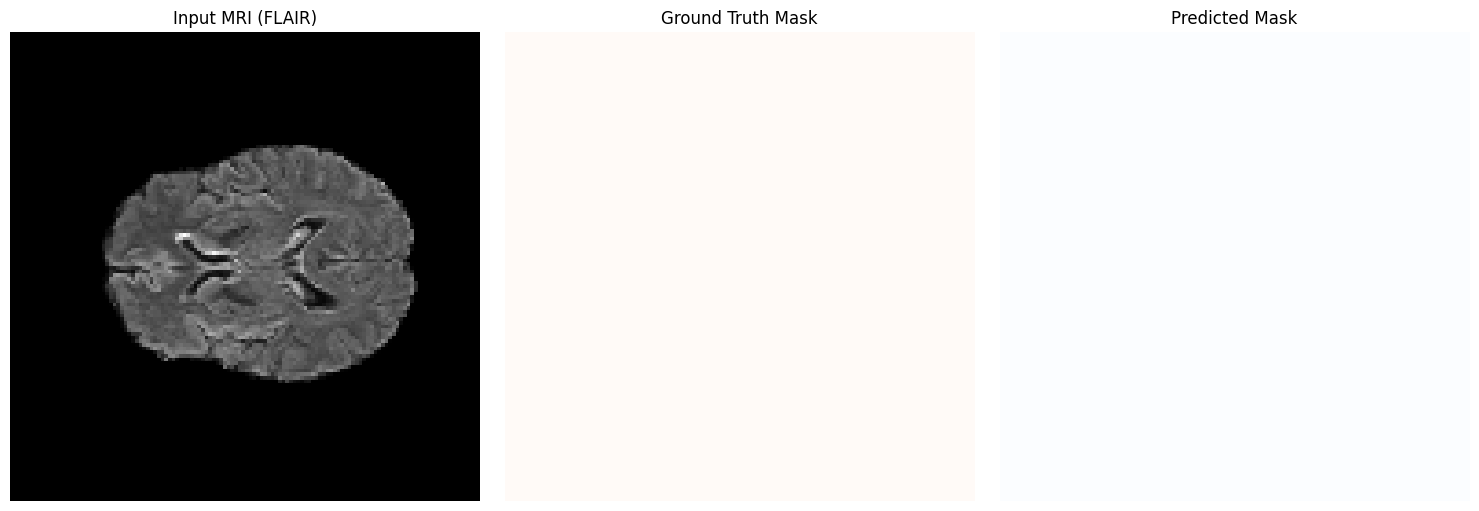


Sample 3:


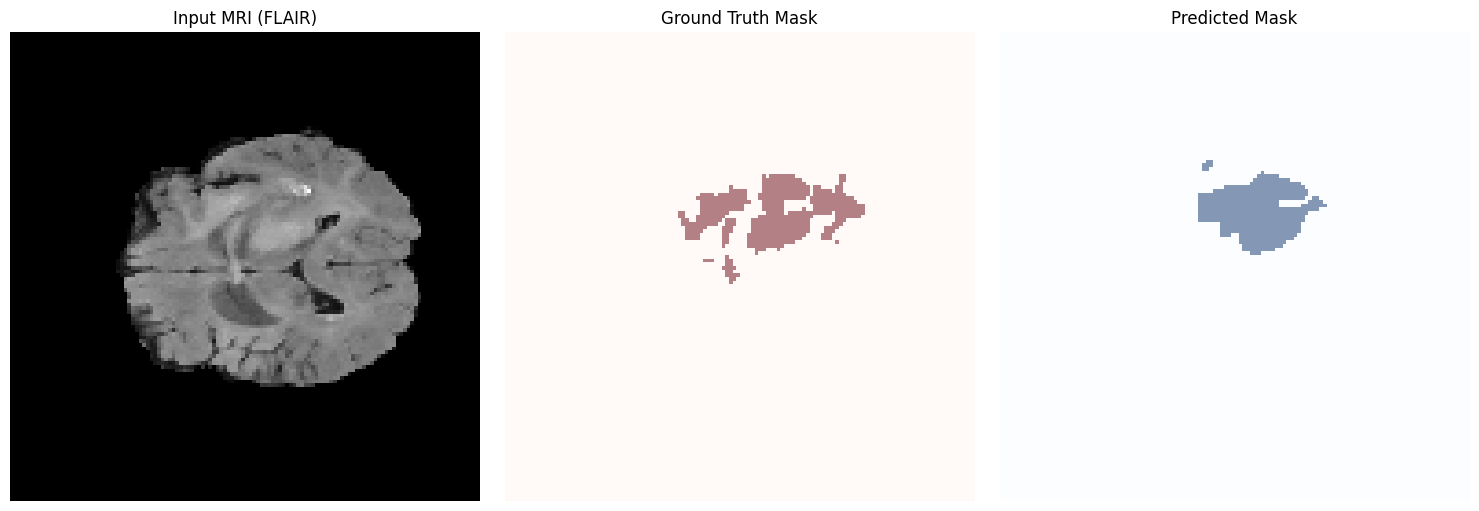


Sample 4:


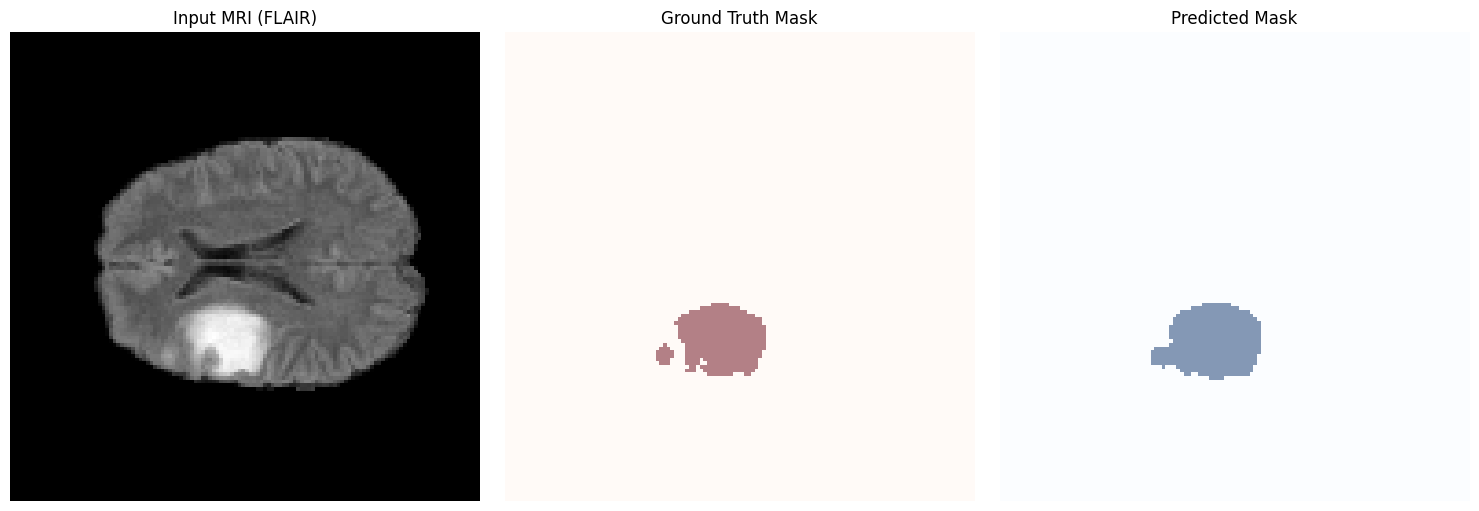


Sample 5:


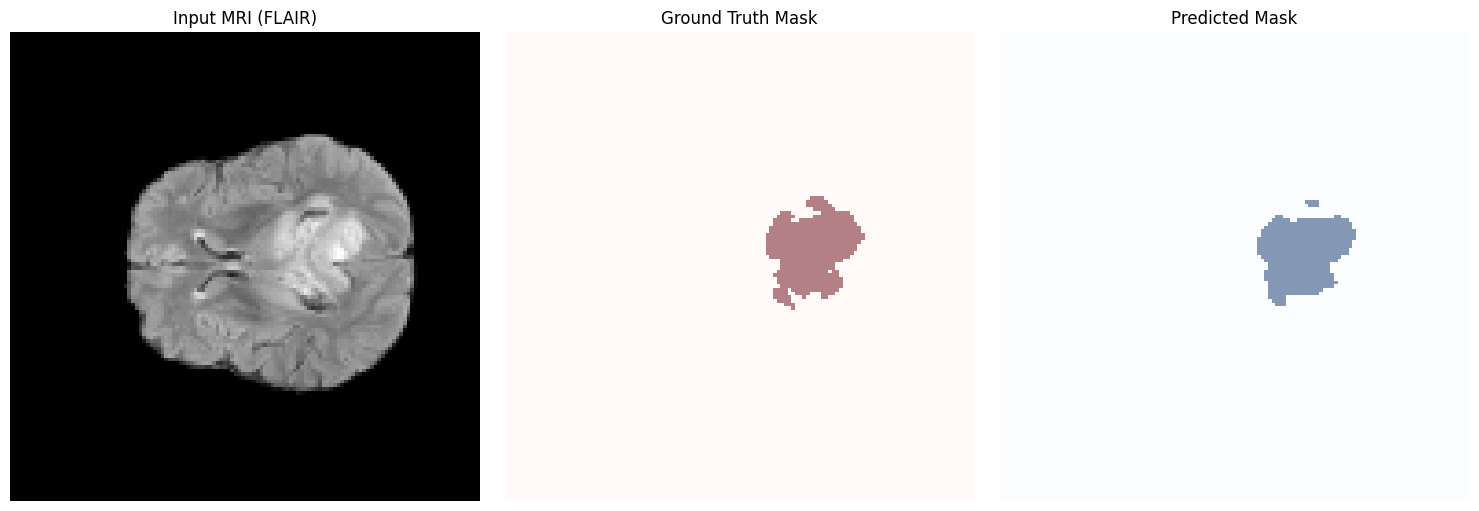

In [ ]:
print("\nEvaluating model on test set...")
loss, dice, iou, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Dice Coefficient: {dice:.4f}")
print(f"Test IoU Coefficient: {iou:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


print("\nVisualizing sample predictions...")
# Select a few random samples from the test set
num_samples_to_plot = 5
random_indices = np.random.choice(len(X_test), num_samples_to_plot, replace=False)

for i, idx in enumerate(random_indices):
    sample_image = X_test[idx]
    sample_ground_truth = y_test[idx]
    sample_prediction = model.predict(np.expand_dims(sample_image, axis=0), verbose=0)[0]

    print(f"\nSample {i+1}:")
    plot_results(sample_image, sample_ground_truth, sample_prediction)